# Import Libraries/Packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 

from keras.models import Sequential  
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
import keras.backend as K

from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, Adam

from keras_tuner import HyperModel
from keras_tuner.tuners import GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Load Dataset

In [2]:
data_train_temp = np.load('kmnist-train-imgs.npz')
labels_train_temp = np.load('kmnist-train-labels.npz')
data_test_temp = np.load('kmnist-test-imgs.npz')
labels_test_temp = np.load('kmnist-test-labels.npz')

In [3]:
data_train = data_train_temp['arr_0']
labels_train = labels_train_temp['arr_0']
data_test = data_test_temp['arr_0']
labels_test = labels_test_temp['arr_0']

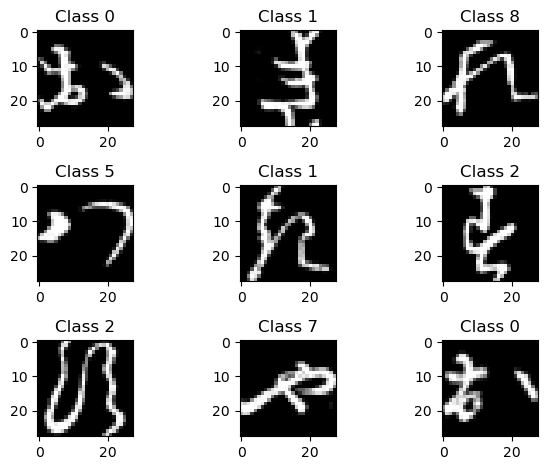

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(data_train))
    plt.imshow(data_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(labels_train[num]))
    
plt.tight_layout()

In [5]:
data_train = data_train.reshape(60000, 784) 
data_test = data_test.reshape(10000, 784)   

data_train = data_train.astype('float32')   
data_test = data_test.astype('float32')

data_train /= 255                        
data_test /= 255

#data_train = data_train.reshape((data_train.shape[0], 28, 28, 1))
#data_test = data_test.reshape((data_test.shape[0], 28, 28, 1))

print("Training matrix shape", data_train.shape)
print("Testing matrix shape", data_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


# Part 1

## Section A: Design and Train SAE Network

In [6]:
hp_sae = HyperParameters()

hp_sae.Int('bottle_neck', min_value=95, max_value=100, step=5);
hp_sae.Choice('batch_size', [32, 64])#, 128, 256]);

32

In [26]:
hp_sae_ce = HyperParameters()

hp_sae.Int('bottle_neck', min_value=95, max_value=100, step=5);
hp_sae.Choice('batch_size', [32, 64])#, 128, 256]);
hp_sae.Choice('sigma', [0.1, 0.2]);

0.1

In [7]:
class SAEHyperModel(HyperModel):
    def build(self, hp):
        model = build_sae(hp)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=2, sampling='log')
        return model.fit(
            *args,
            batch_size=batch_size,
            #hp_sae.Choice('batch_size', [32, 64, 128, 256]),
            **kwargs
        )

In [ ]:
class SAECEHyperModel(HyperModel):
    def build(self, hp):
        sigma = hp.Choice('sigma', [0.1,0.2])
        
        model = build_sae(hp)
        model.compile(optimizer='adam', loss=correntropy(sigma))
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=2, sampling='log')
        return model.fit(
            *args,
            batch_size=batch_size,
            #hp_sae.Choice('batch_size', [32, 64, 128, 256]),
            **kwargs
        )

In [9]:
def correntropy_loss(sigma):
    def loss(y_true, y_pred):
        kernel = K.exp(-K.square(y_pred - y_true) / (2 * sigma * sigma))
        return -K.mean(kernel)
    return loss

In [10]:
def build_enc(neck_width):
    #neck_width = hp.Int('bottle_neck', min_value=50, max_value=100, step=5)
    
    enc_model = Sequential()
    enc_model.add(Dense(784,))
    enc_model.add(Dense(800, activation='relu'))
    enc_model.add(Dense(200, activation='relu'))
    enc_model.add(Dense(neck_width, activation='relu'))
    return enc_model

In [11]:
def build_dec(neck_width):
    #neck_width = hp.Int('bottle_neck', min_value=50, max_value=100, step=5)
    
    dec_model = Sequential()
    dec_model.add(Dense(neck_width,))
    dec_model.add(Dense(200, activation='relu'))
    dec_model.add(Dense(800, activation='relu'))
    dec_model.add(Dense(784,))
    return dec_model

In [12]:
def build_sae(hp):
    neck_width = hp.Int('bottle_neck', min_value=50, max_value=100, step=5)
    
    enc_model = build_enc(neck_width)
    dec_model = build_dec(neck_width)
    
    sae_model = Sequential()
    sae_model.add(enc_model)
    sae_model.add(dec_model)
    
    return sae_model

In [13]:
sae_tuner = GridSearch(
    SAEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae,
    max_retries_per_trial=20,
    directory='sae_tuner',
    project_name='sae_tuning'
)

In [ ]:
sae_ce_tuner = GridSearch(
    SAECEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae,
    max_retries_per_trial=20,
    directory='sae_ce_tuner',
    project_name='sae_ce_tuning'
)

In [14]:
callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.001)

sae_tuner.search(data_train, data_train, epochs=1, validation_split=0.3, callbacks=[callback])

Trial 4 Complete [00h 00m 18s]
loss: 0.050037045031785965

Best loss So Far: 0.046765219420194626
Total elapsed time: 00h 01m 38s


In [15]:
best_sae = sae_tuner.get_best_models(num_models=1)[0]

In [17]:
best_sae.fit(data_train, data_train)

1875/1875 [==============================] - 36s 19ms/step - loss: 0.1120


In [27]:
best_encoder = best_sae.layer[0]

In [19]:
bottle_neck_layer = best_encoder.layer[-1]
neck_width = bottle_neck_layer.units

In [20]:
encoded_train_data = best_encoder.predict(data_train)
encoded_test_data = best_encoder.predict(data_test)

313/313 [==============================] - 1s 4ms/step


In [ ]:
callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.001)

sae_ce_tuner.search(data_train, data_train, epochs=1, validation_split=0.3, callbacks=[callback])

In [ ]:
best_sae_ce = sae_ce_tuner.get_best_models(num_models=1)[0]

In [ ]:
best_sae_ce.fit(data_train, data_train)

In [ ]:
best_encoder_ce = best_sae_ce.layer[-1]

In [ ]:
bottle_neck_layer_ce = best_encoder_ce.layer[-1]
neck_width_ce = bottle_neck_layer_ce.units

In [ ]:
encoded_train_data_ce = best_encoder_ce.predict(data_train)
encoded_test_data_ce = best_encoder_ce.predict(data_test)

## Section B: Design and Train SAE+Classifier

In [21]:
hp_clf = HyperParameters()

hp_clf.Int('clf_width', min_value=5, max_value=20, step=5);
hp_clf.Int('clf_height', min_value=1, max_value=3, step=1);
#hp_clf.Int('batch_size', min_value=32, max_value=256, step=2, sampling='log');
hp_clf.Choice('batch_size', [32,64,128,256]);
hp_clf.Choice('neck_width', [neck_width]);

In [22]:
def build_mlp(hp):
    cw = hp_clf.Int('clf_width', min_value=5, max_value=20, step=5)
    ch = hp_clf.Int('clf_height', min_value=1, max_value=3, step=1)
    neck_w = hp_clf.Choice('neck_width', [neck_width])
    
    mlp_model = Sequential()
    mlp_model.add(Dense(neck_w,))
    for i in range(ch):
        mlp_model.add(Dense(cw, activation='relu'))
    mlp_model.add(Dense(10,))
    
    return mlp_model

In [23]:
class CLFHyperModel(HyperModel):
    def build(self, hp):
        model = build_mlp(hp)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=2, sampling='log')
        return model.fit(
            *args,
            batch_size=batch_size,
            #hp_sae.Choice('batch_size', [32, 64, 128, 256]),
            **kwargs
        )

In [24]:
clf_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='clf_tuner',
    project_name='clf_tuning'
)

In [25]:
callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.001)

clf_tuner.search(encoded_train_data, labels_train, epochs=1, validation_split=0.3, callbacks=[callback])

Trial 48 Complete [00h 00m 01s]
loss: 27.42662811279297

Best loss So Far: 5.461320877075195
Total elapsed time: 00h 01m 57s


## Section C: Inject Noise

In [ ]:
def add_noise(X, noise_level=0.10):
    """
    Add salt and pepper noise to a NumPy array.

    Parameters:
    - X: NumPy array (image or any numerical array)
    - noise_level: Proportion of elements to be altered. Default is 0.05 (5%)
    
    Returns:
    - Noisy array
    """

    # Copy the input array to avoid overwriting the original data
    X_noisy = np.copy(X)

    # Calculate the number of elements to be affected by noise
    num_noise = int(noise_level * X.size)

    # Choose random locations to place the salt and pepper noise
    coords = [np.random.randint(0, i - 1, num_noise) for i in X.shape]

    # Add salt noise (maximum value)
    X_noisy[tuple(coords)] = np.max(X)

    # Choose random locations for pepper noise
    coords = [np.random.randint(0, i - 1, num_noise) for i in X.shape]

    # Add pepper noise (minimum value)
    X_noisy[tuple(coords)] = np.min(X)

    return X_noisy

# Example usage
# Assuming 'array' is your numpy array:
# noisy_array = add_salt_and_pepper_noise(array, noise_level=0.05)